<img src="image.png" width="60%">

# SENSE-CHECK: Filtering AI Hallucinations

While Artificial Intelligence revolutionizes how we learn, its tendency to "hallucinate" with unwavering confidence remains a significant threat to academic trust. In this Data4Good Case Challenge, I developed a high-precision pipeline to bridge the gap between generative power and factual reliability, ensuring AI-generated knowledge is rigorously audited for digital learners. My goal was to engineer a **Transformer-based diagnostic framework** that dissects the fine line between factual truth, subtle contradictions, and irrelevant noise—transforming AI from a source of misinformation into a truly reliable mentor.

## Project Approach Overview
The methodology I implemented in my notebook consists of two main steps: **data exploration & visualization** and **text classification models**:

- ### 1. Data Exploration and Visualizations:

  During the exploratory data analysis, I systematically investigated the training dataset to identify the signals that distinguish **factual accuracy** from incorrect responses. The analysis revealed a significant **class imbalance** dominated by factual answers, which directly dictated my use of a **stratified splitting strategy** and **weighted evaluation metrics**. While structural analysis showed that **contradiction answers** are typically shorter, the high overlap in length distributions between factual and irrelevant classes proved that surface-level features are insufficient for reliable classification. Further investigation into **lexical overlap** and **n-gram patterns** demonstrated that while factual and irrelevant answers share similar vocabularies, factual responses exhibit much tighter **contextual grounding** and frequency. Most importantly, identifying **procedural artifacts** within the contradiction class allowed me to distinguish genuine semantic signals from coincidental patterns. These insights collectively justified the transition to **Transformer-based semantic analysis**, ensuring the final model focuses on deep logical connections rather than shallow textual cues.

  <br>

- ### 2. Text Classification Models:

  My approach focused on moving beyond simple word-matching toward **deep semantic reasoning** through a two-stage pipeline. I began by establishing a **TF-IDF + Logistic Regression baseline**, which revealed that while surface-level patterns work for factual answers, they fail to distinguish **contradictions and irrelevant responses** that share similar keywords. This confirmed that vocabulary alone is insufficient, leading me to adopt a **BERT-based architecture** that processes inputs holistically to catch nuanced logical inconsistencies. To handle the **83% class imbalance**, I integrated **Custom Class Weights** and employed a selective **fine-tuning strategy** by freezing base layers while training the last two encoder layers to stabilize learning. This transition resulted in a **Macro F1-score of 0.93**, proving the model's reliability across all categories. By moving past shallow cues to **context-grounded reasoning**, the final model effectively separates plausible-sounding incorrect answers from factual truth, with error patterns now concentrated only between semantically similar meanings

Thank you for reviewing this project and for your interest in making AI-generated knowledge more reliable and trustworthy for everyone.

### Dataset Summary

The data provided is a Questions/Answer dataset to determine if the answer is **factual**, not factual **(contradiction)**, or **irrelevant** to the question.

- **Question:** The question asked/prompted for
- **Context:** Relevant contextual support for the question
- **Answer:** The answer provided by an AI
- **Type:** A categorical variable with three possible levels – Factual, Contradiction, Irrelevant:
    - **Factual:** the answer is correct
    - **Contradiction:** the answer is incorrect
    - **Irrelevant:** the answer has nothing to do with the question

**Training Set:** 21,021 examples (used for analysis and model development).

**Test Set:** 2,000 examples (used for final classification and evaluation).

---

## Import Libraries

In this section, I'll import the libraries required for data handling and model development.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer,AutoModelForSequenceClassification

import warnings
warnings.filterwarnings('ignore')

---

## Loading and Inspecting the Datasets

We begin by loading and inspecting the ``train.json`` and ``test.json`` datasets to understand their structure and overall content.

In [2]:
# load the train.json file
data_path_train = "data/train.json"
with open(data_path_train, 'r', encoding='utf-8') as f:
    data_train = json.load(f)

# load the test.json file
data_path_test = "data/test.json"
with open (data_path_test, 'r', encoding="utf-8") as f:
    data_test = json.load(f)

# convert to DataFrame
train_df = pd.DataFrame(data_train)
test_df = pd.DataFrame(data_test)

# show the first 5 rows
display(train_df.head())
display(test_df.head())

,answer,type,context,question
0,"In 1512, Parliament passed a significant act t...",factual,During the Hundred Years' War a French attack ...,In what year did Parliament pass a notable law...
1,The Spanish and French were the ones who estab...,factual,"""By May 1539, Conquistador Hernando de Soto sk...",Who established early settlements in Florida
2,"Traditionally, monsoons in Punjab are expected...",factual,The onset of the southwest monsoon is anticipa...,When do monsoons traditionally happen in Punjab?
3,The media made the requests for Kondo to use o...,factual,Media requests at the trade show prompted Kond...,Who made the requests for Kondo to use orchest...
4,According to historians Robert Friedel and Pau...,factual,In addressing the question of who invented the...,How many inventors came up with electric lamps...


,ID,answer,type,context,question
0,1,"In the mid-19th century, the Bronx was referre...",,The Bronx street grid is irregular. Like the n...,What was the Bronx called in the mid-19th cent...
1,2,"Beyoncé's father, Mathew Knowles, began managi...",,,When did Beyoncé begin to manage the girl group?
2,3,Dionysus was similar to the Roman god Bacchus.,,"While the new plebeian nobility made social, p...",To what Roman god was Dionysus similar?
3,4,The most crucial defense in preventing the spr...,,"Techniques like hand washing, wearing gowns, a...",What is the most important defense against the...
4,5,The third largest long term acute care provide...,,The Baylor College of Medicine has annually be...,What is the third largest acute care center in...


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21021 entries, 0 to 21020
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   answer    21021 non-null  object
 1   type      21021 non-null  object
 2   context   21021 non-null  object
 3   question  21021 non-null  object
dtypes: object(4)
memory usage: 657.0+ KB


**Quick summary and initial observations - Train Set:**

- The train dataset consists of **21,021 samples** and **4 columns**, all stored as **object** data types.

- All columns — question, context, answer, and type — are fully populated, indicating that there are **no missing values** in the dataset.

- As all variables are **text-based**, the dataset cannot be directly utilized by conventional numerical machine learning algorithms and therefore requires **text preprocessing and appropriate feature representation techniques**, such as TF-IDF or transformer-based embeddings, prior to model training.

Overall, the dataset is well-structured and clean, providing a solid foundation for building a multi-class text classification model to assess the factual consistency and relevance of AI-generated answers.

In [4]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        2000 non-null   int64 
 1   answer    2000 non-null   object
 2   type      2000 non-null   object
 3   context   2000 non-null   object
 4   question  2000 non-null   object
dtypes: int64(1), object(4)
memory usage: 78.3+ KB


**Quick summary and initial observations - Test Set:**

- The test dataset consists of **2,000** samples and **5** columns.
  
- All columns are fully populated, indicating **no missing values**.
  
- The textual fields **(question, context, and answer)** follow the same structure as the training data.

  
- An additional **ID** column is included for sample identification during submission.

In [5]:
train_df.describe()

,answer,type,context,question
count,21021,21021,21021,21021
unique,20670,3,12441,21018
top,1945,factual,,What was the name of Alonso de Salazar's ship?
freq,6,17431,1869,2


**Descriptive summary:**

- The training set contains 21,021 samples across all text fields.

- The **answer** and **question** columns exhibit a **high level of uniqueness**, indicating substantial textual diversity with minimal repetition, while the **context** field includes repeated entries, suggesting shared contextual information across multiple samples.

- The target variable type consists of three classes  — factual, contradiction, irrelevant  —, with factual being the dominant label, indicating a **class imbalance** that should be considered during model training and evaluation.

Overall, these characteristics highlight important data distribution properties that may influence feature representation choices and evaluation strategies

In [6]:
train_df.duplicated().sum() # checking duplicate rows

np.int64(1)

In [7]:
train_df.drop_duplicates(inplace=True) # remove duplicate rows to maintain dataset integrity

---

## Data Exploration and Visualization

**What Is the Distribution of the Type Column, and How Does It Affect Model Training?**

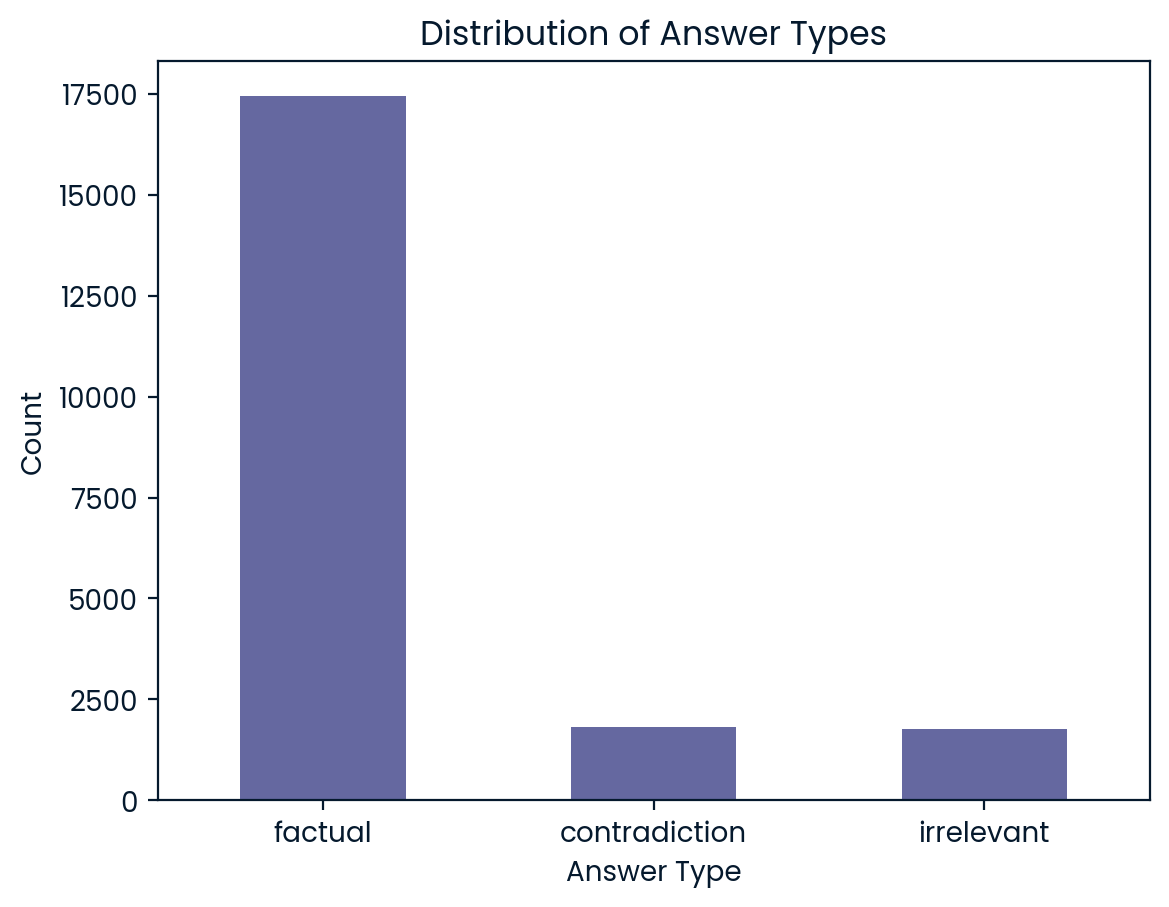

In [8]:
type_counts = train_df['type'].value_counts()

plt.figure()
type_counts.plot(kind='bar')
plt.title('Distribution of Answer Types')
plt.xlabel('Answer Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

Given the observed **class imbalance**, we will take this into account during model development, as models trained on imbalanced data tend to favor the majority class, in this case Factual.

Specifically, we will **preserve class proportions** when splitting the training data into training and validation sets, and we will explore the use of **class weighting** during training.

Also, we will focus on **evaluation metrics** that capture performance across all classes, rather than **accuracy** alone.

**What is the Word Count Distribution of Answers?**

In [9]:
train_df_copy = train_df.copy()
train_df_copy["answer_word_count"] = train_df_copy["answer"].apply(lambda x: len(x.split()))

answer_length_stats = train_df_copy["answer_word_count"].describe()
answer_length_stats

count    21020.000000
mean        14.325547
std          6.894139
min          1.000000
25%         10.000000
50%         13.000000
75%         18.000000
max         92.000000
Name: answer_word_count, dtype: float64

When examining the answer column, we observe that responses are generally concise, with an average length of approximately **14 words** per answer.

The variation in length is moderate **(std ≈ 7 words)**, indicating that most answers fall within a relatively consistent range, while still allowing for some flexibility in expression. The median values are close to the means, suggesting a fairly balanced distribution without strong skewness.

At the same time, the presence of very short answers **(as short as 1 word)** alongside a small number of substantially longer responses **(up to 92 words)** highlights variability in response style and completeness.

Overall, these statistics suggest that while answer length varies, most responses are sufficiently informative yet compact, reinforcing the need to rely on semantic content rather than length-based heuristics when modeling factual consistency and relevance.

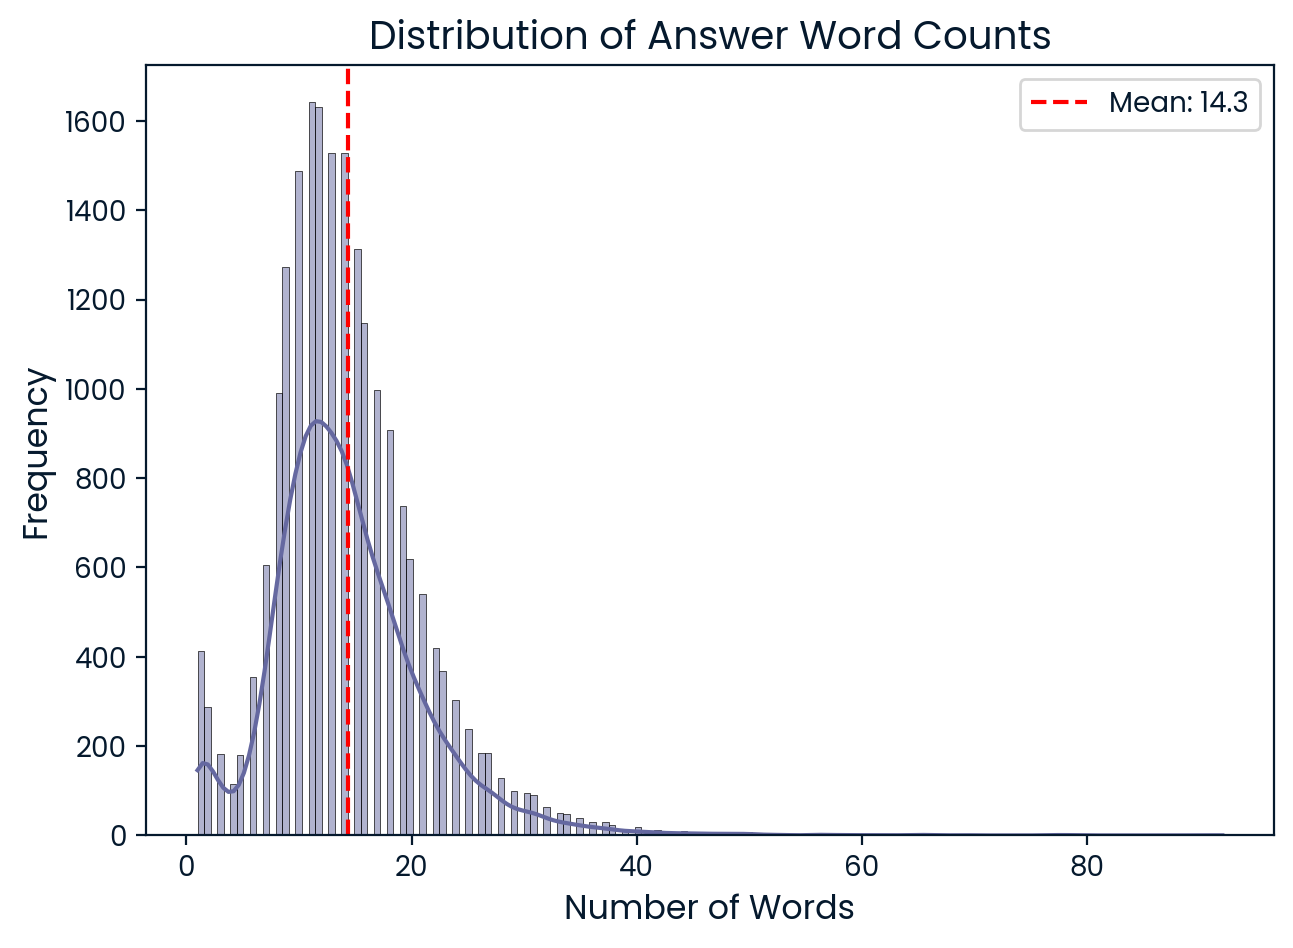

In [10]:
# Visualize the distribution of answer word counts
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
sns.histplot(train_df_copy['answer_word_count'], kde=True)
plt.title('Distribution of Answer Word Counts', fontsize=14)
plt.xlabel('Number of Words', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(x=answer_length_stats['mean'],
            color='red', linestyle='--', label=f"Mean: {answer_length_stats['mean']:.1f}")
plt.xlim()
plt.legend()
plt.show()

The distribution of answer word counts is **right-skewed**, with the majority of responses clustered between **10 and 20** words. The mean value (≈ 14.3 words) aligns closely with the central mass of the distribution, indicating that most answers are relatively concise.

A long tail extending toward higher word counts suggests the presence of a smaller number of substantially longer answers, while very short responses also occur but with lower frequency. This pattern reflects variability in answer verbosity **without extreme dominance of outliers**.

Overall, the distribution confirms that answer length varies meaningfully across samples, but remains within a reasonable range for text modeling, supporting the use of standard text representations without aggressive truncation or length-based filtering.

**How does the length of answers (in terms of word count) vary across different types?**

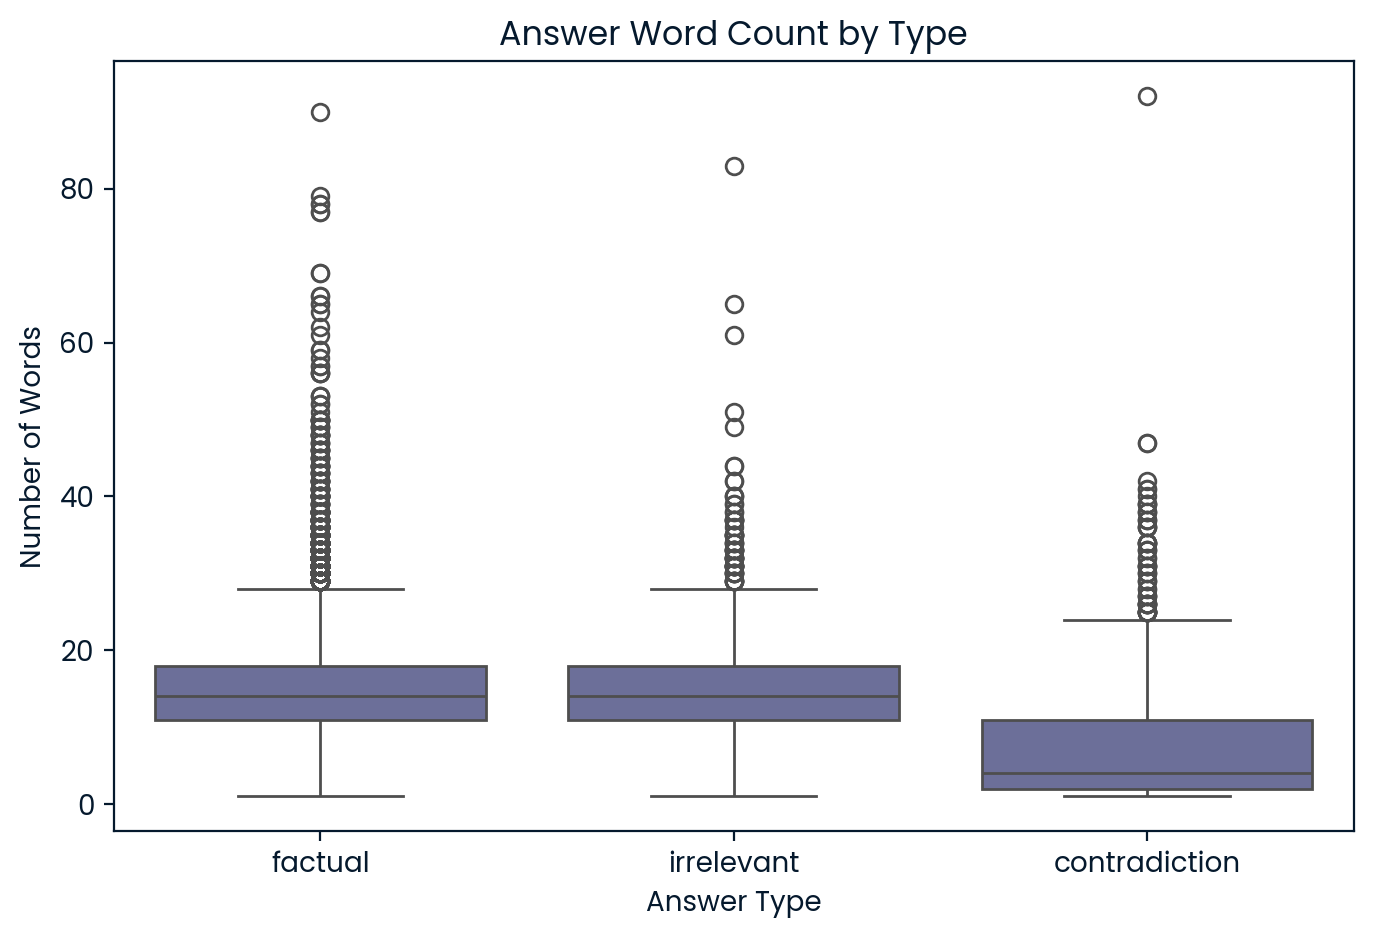

In [11]:
plt.figure(figsize=(8, 5))
sns.boxplot(x="type", y="answer_word_count", data=train_df_copy)
plt.title("Answer Word Count by Type")
plt.xlabel("Answer Type")
plt.ylabel("Number of Words")
plt.show()

The boxplot illustrates clear differences in answer word count across the three classes.

- **Contradiction** answers are consistently **shorter**, with a noticeably **lower median** and a **tighter interquartile range**, indicating that incorrect responses tend to be brief and less elaborative.

- In contrast, **factual and irrelevant answers** show highly **overlapping distributions**, with **similar medians and variability**. This overlap suggests that answer length alone does not provide sufficient discriminative power to distinguish between correct and irrelevant responses.

- The presence of outliers across all classes reflects occasional verbose answers, but these do **not alter the overall pattern**.

Overall, the visualization confirms that while **short** answer length is a strong indicator of contradictions, **semantic content is required** to reliably separate **factual and irrelevant answers**.

**What is the Word Count Distribution of Questions?**

In [12]:
train_df_copy["question_word_count"] = train_df_copy["question"].apply(lambda x: len(str(x).split()))

question_length_stats = train_df_copy["question_word_count"].describe()
question_length_stats

count    21020.000000
mean        10.072502
std          3.586715
min          2.000000
25%          8.000000
50%         10.000000
75%         12.000000
max         34.000000
Name: question_word_count, dtype: float64

- The dataset contains **21,020 questions**, with an average length of approximately **10 words**.

- The relatively low standard deviation **(≈3.6 words)** indicates that question lengths are fairly consistent across the dataset.

- The **median value (10 words)** closely matches the mean, suggesting a balanced distribution without strong skewness.

- Most questions fall within the **8–12 word** range, as reflected by the interquartile range.

- While the shortest questions contain only **2 words**, the maximum length reaches **34 words**, indicating the presence of a small number of longer, more detailed questions. However, these appear to be outliers rather than the norm.

Overall, the results suggest that the dataset predominantly consists of concise and uniformly structured questions, which is desirable for maintaining consistency in model input.

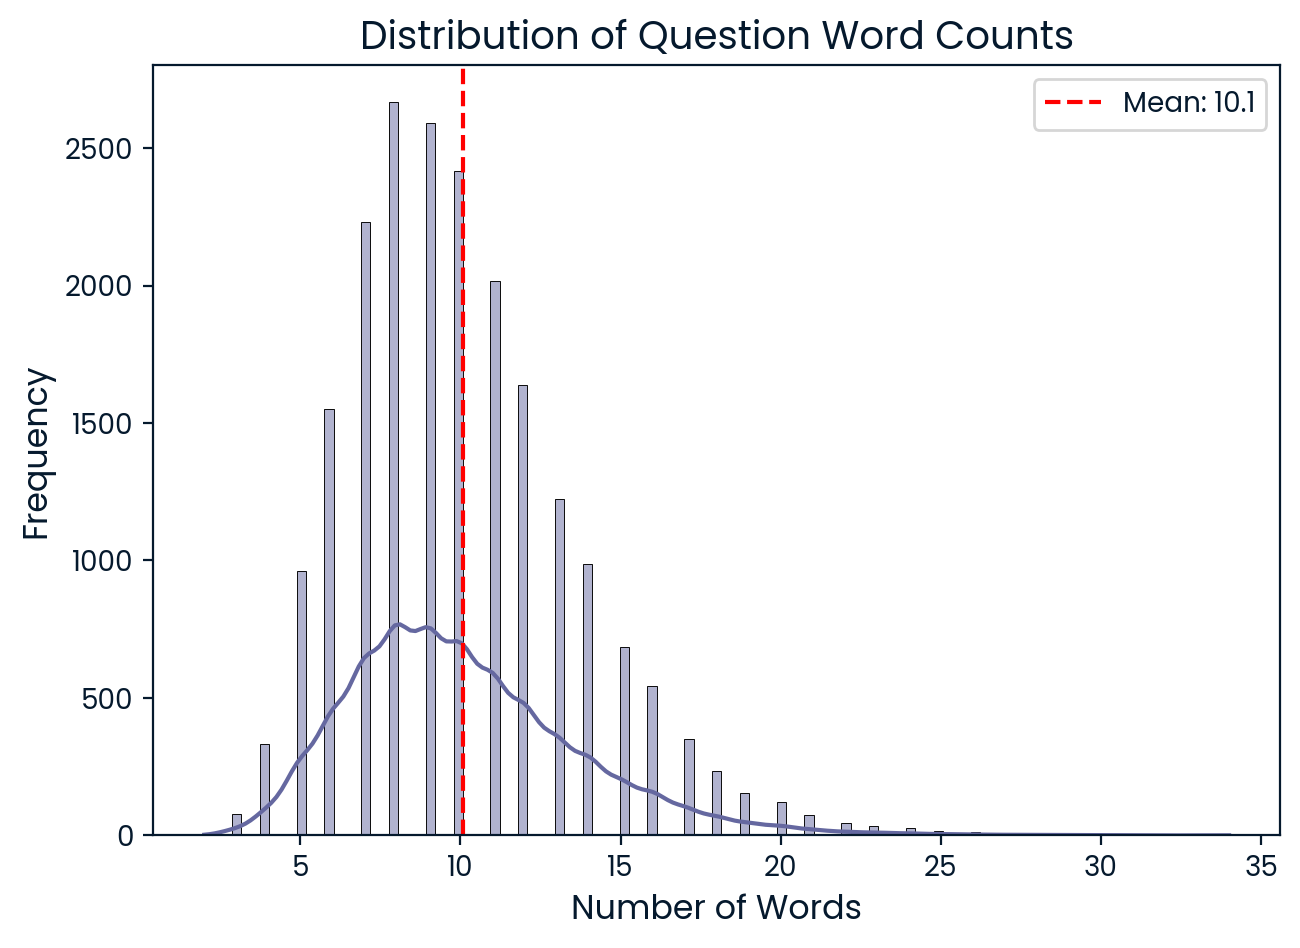

In [13]:
# Visualize the distribution of word counts
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
sns.histplot(train_df_copy['question_word_count'], kde=True)
plt.title('Distribution of Question Word Counts', fontsize=14)
plt.xlabel('Number of Words', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(x=question_length_stats['mean'],
            color='red', linestyle='--', label=f"Mean: {question_length_stats['mean']:.1f}")
plt.xlim()
plt.legend()
plt.show()

- The histogram shows that question lengths are mostly concentrated between **6 and 14 words**, with a clear peak around **10 words**. 

- This indicates that most questions are **short and clearly** formulated.

- While a small number of longer questions exist, the overall distribution remains compact and well-controlled, which helps reduce variability in model inputs.

**What is the Word Count Distribution of Context?**

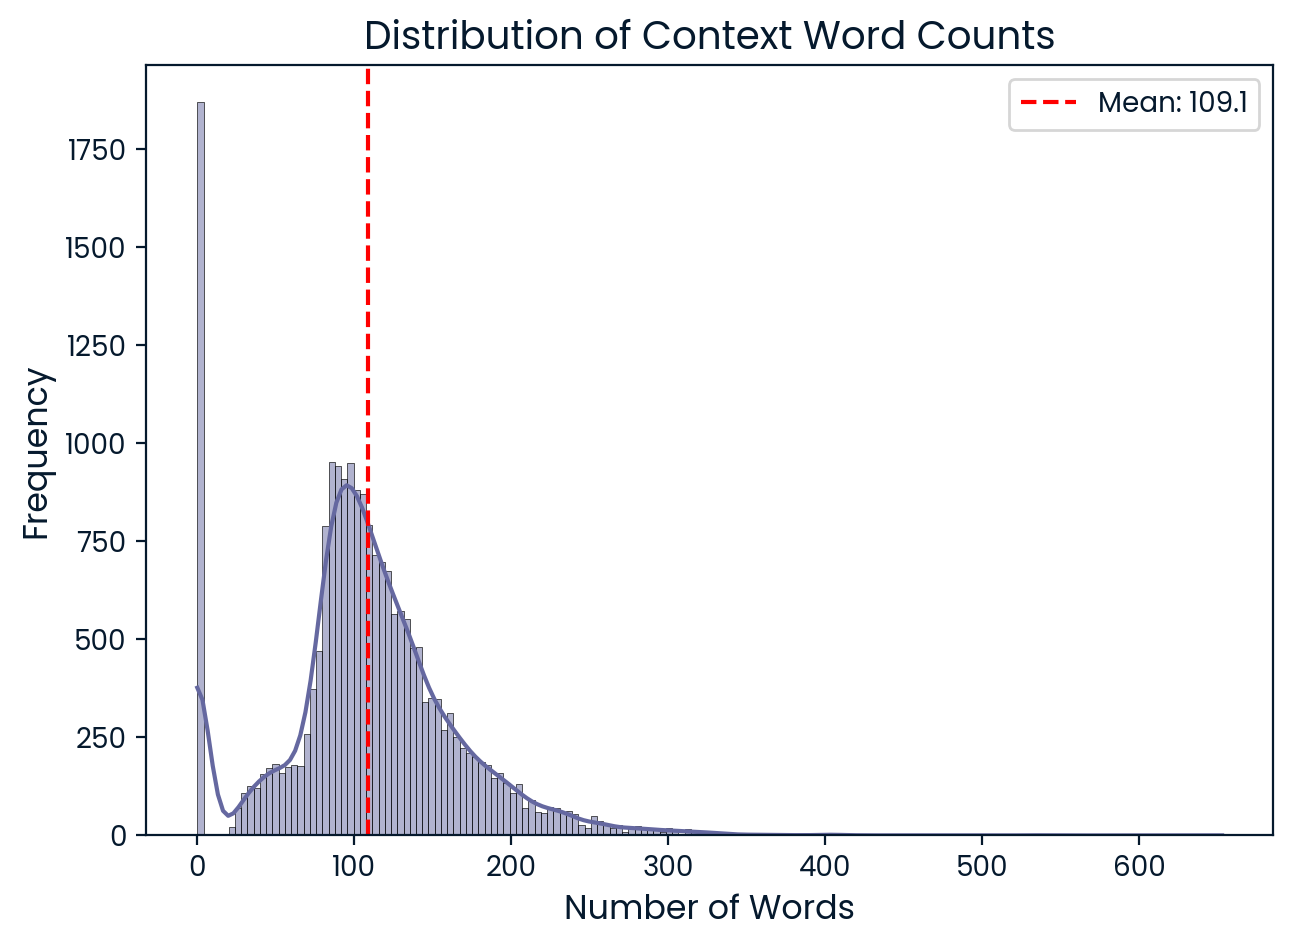

In [14]:
train_df_copy["context_word_count"] = train_df_copy["context"].apply(lambda x: len(str(x).split()))
context_length_stats = train_df_copy["context_word_count"].describe()

# Visualize the distribution of word counts
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
sns.histplot(train_df_copy['context_word_count'], kde=True)
plt.title('Distribution of Context Word Counts', fontsize=14)
plt.xlabel('Number of Words', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(x=context_length_stats['mean'],
            color='red', linestyle='--', label=f"Mean: {context_length_stats['mean']:.1f}")
plt.xlim()
plt.legend()
plt.show()

- The histogram shows that context lengths are considerably **longer and more variable** than both **questions and answers**, with an average length of around **109 words**. 

- The distribution is **right-skewed**, meaning that while most contexts fall within a moderate range, a smaller number of samples contain very long passages. 

- This variability indicates that the model must process **heterogeneous contextual inputs**, which increases task difficulty by requiring consistent information extraction across different context lengths.

**How does the proportion of shared words between the answer and the question, and between the answer and the context, differ across answer types?**

This analysis examines whether word-level overlap can help differentiate answer types. I measure how many words in the answer also appear in the question and in the context.

Factual answers are expected to reuse key terms from the question or context, resulting in higher overlap. In contrast, irrelevant answers typically share fewer words, while contradiction answers may reuse similar words but express opposing meanings.

Comparing overlap distributions across answer types provides insight into how much simple lexical similarity reflects answer correctness and relevance, and why deeper contextual understanding is required beyond keyword matching.

In [15]:
def calculate_overlap(row, col1, col2):
    """
    Calculates the common word ratio between two columns,
    based on the total number of words in the first column (col1).
    """
    words1 = set(str(row[col1]).lower().split())
    words2 = set(str(row[col2]).lower().split())

    if not words1:
        return 0

    shared_words = words1.intersection(words2)
    return len(shared_words) / len(words1)

**Answer vs Question**

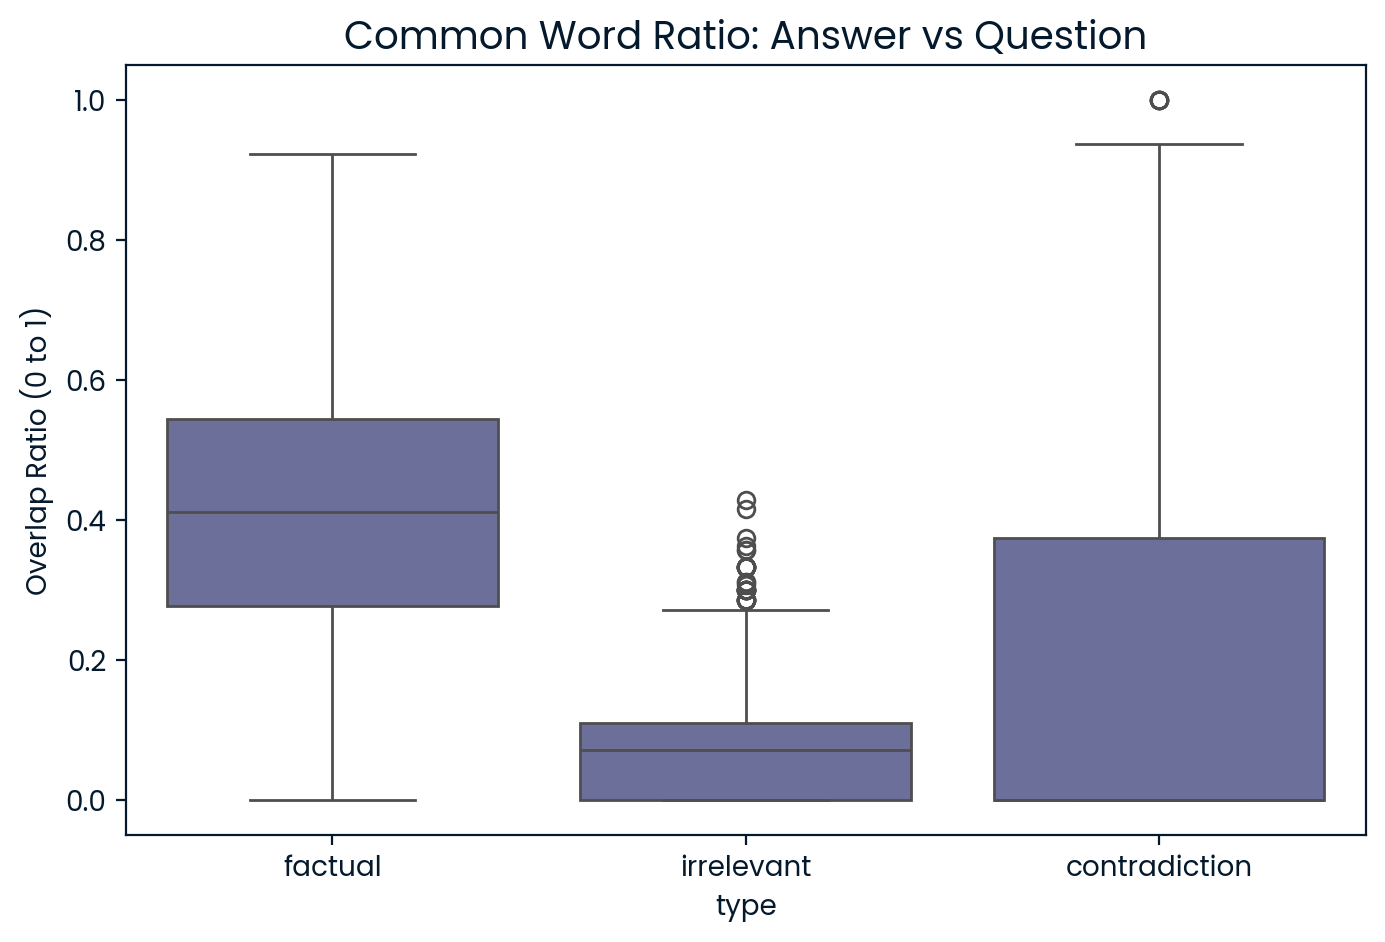

In [16]:
train_df_copy['answer_question_overlap'] = train_df_copy.apply(
    lambda row: calculate_overlap(row, 'answer', 'question'), axis=1
)

plt.figure(figsize=(8, 5))
sns.boxplot(x='type', y='answer_question_overlap', data=train_df_copy)
plt.title('Common Word Ratio: Answer vs Question', fontsize=14)
plt.ylabel('Overlap Ratio (0 to 1)')
plt.show()

- The boxplot shows that **factual answers** tend to share a higher proportion of common words with the corresponding questions, indicating that correct responses are generally aligned with the question’s wording and focus.

- In contrast, **irrelevant answers** exhibit very low overlap ratios, suggesting that these responses often fail to directly address the question, both lexically and semantically.

- The **contradiction** class displays a wide and irregular distribution. While some contradictory answers reuse question terms, they do so inconsistently, reflecting cases where key words are present but the conveyed meaning conflicts with the question.

Overall, this analysis indicates that **answer–question lexical overlap provides a useful supporting signal**, particularly for distinguishing factual and irrelevant answers. However, due to the variability observed—especially within the contradiction class—this feature alone is insufficient and should be complemented with context-aware semantic representations during model development.

**Answer vs Context**

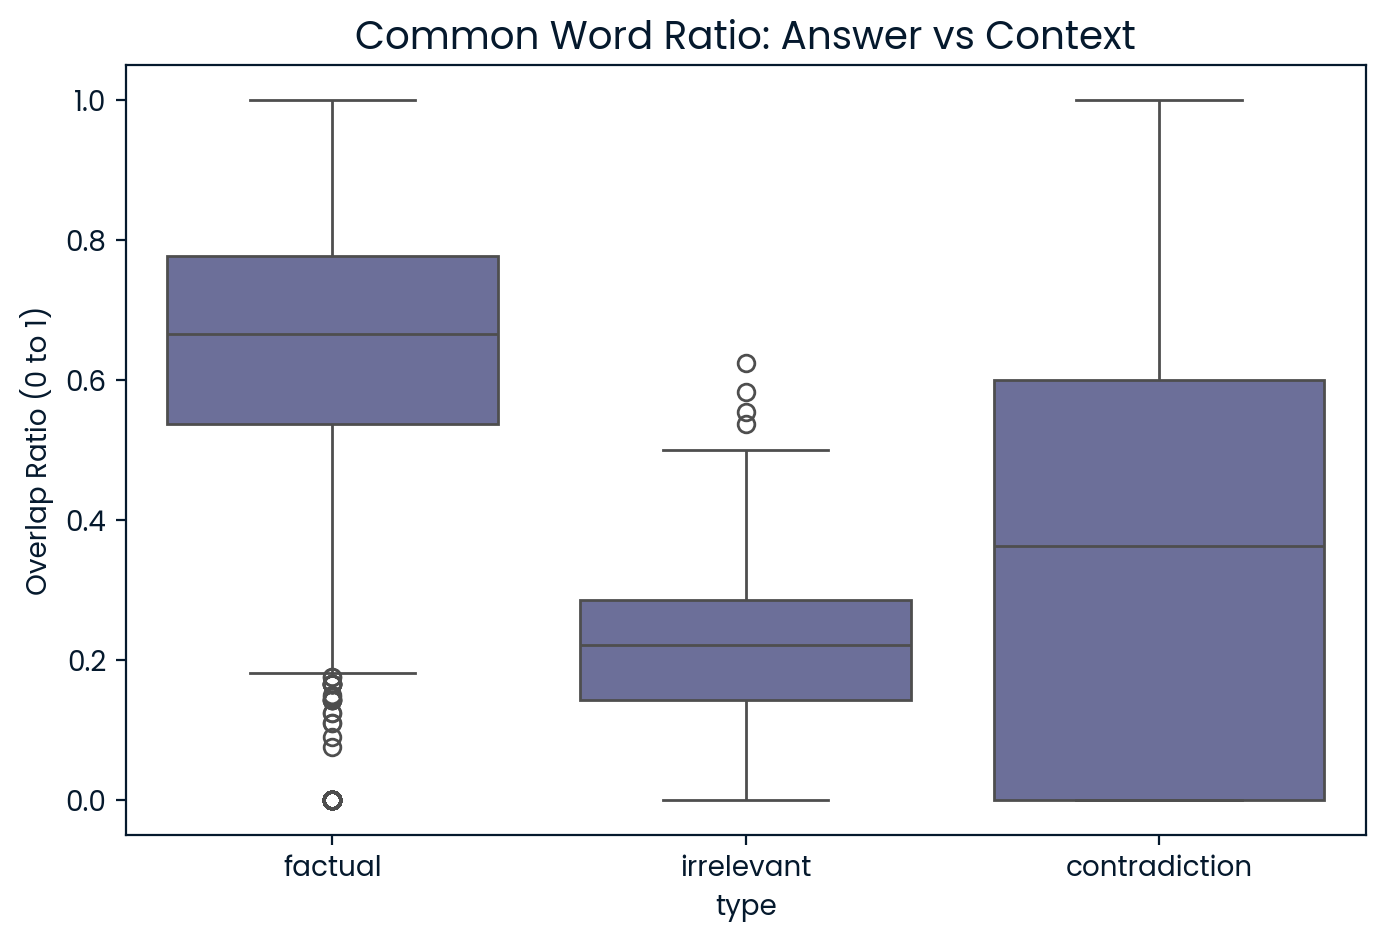

In [17]:
train_df_copy['answer_context_overlap'] = train_df_copy.apply(
    lambda row: calculate_overlap(row, 'answer', 'context'), axis=1
)

plt.figure(figsize=(8, 5))
sns.boxplot(x='type', y='answer_context_overlap', data=train_df_copy)
plt.title('Common Word Ratio: Answer vs Context', fontsize=14)
plt.ylabel('Overlap Ratio (0 to 1)')
plt.show()

- Factual answers show noticeably **higher overlap ratios**, indicating that correct responses tend to draw directly from the contextual information and reuse relevant terminology.

- Irrelevant answers, on the other hand, exhibit **substantially lower overlap**, suggesting that these responses fail to meaningfully incorporate the provided context despite having similar length characteristics.

- Contradiction answers present a **broad and uneven distribution**. While some contradictory responses reuse contextual terms, they often do so without preserving the original meaning, highlighting that surface-level overlap alone is insufficient to capture logical inconsistency.

Overall, this analysis shows that answer–context lexical overlap is a strong signal for factual grounding, whereas distinguishing contradictions requires deeper semantic understanding beyond shared words.

**Are there characteristic bigram patterns that distinguish factual, contradiction, and irrelevant answers?**

This analysis explores whether different answer types exhibit distinctive lexical patterns at the bigram level. By examining the most frequent bigrams within factual, contradiction, and irrelevant answers separately, I aim to identify class-specific phrasing tendencies.

The motivation is that factual answers may rely on informative or explanatory word pairs, while contradiction answers may contain negation or contrastive expressions, and irrelevant answers may show more generic or off-topic language.

Identifying such patterns helps assess whether surface-level phrase usage reflects underlying semantic differences between classes and provides intuition for why contextual models like BERT are necessary beyond simple n-gram features.

In [18]:
def get_top_ngram(corpus, n=None, top_k=10):
    """
    Returns the n-grams that occur most frequently in a given text string.
    """
    vec = CountVectorizer(ngram_range=(n, n), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    return words_freq[:top_k]

In [19]:
# first separate them by class.
factual_answers = train_df_copy[train_df_copy['type'] == 'factual']['answer']
contradiction_answers = train_df_copy[train_df_copy['type'] == 'contradiction']['answer']
irrelevant_answers = train_df_copy[train_df_copy['type'] == 'irrelevant']['answer']

# then get the top 10 bigrams for each class.
top_factual = get_top_ngram(factual_answers, n=2, top_k=10)
top_contradiction = get_top_ngram(contradiction_answers, n=2, top_k=10)
top_irrelevant = get_top_ngram(irrelevant_answers, n=2, top_k=10)

# finally gather these in a DataFrame.
ngram_comparison = pd.DataFrame({
    'Factual Bigrams': [f"{w} ({c})" for w, c in top_factual],
    'Contradiction Bigrams': [f"{w} ({c})" for w, c in top_contradiction],
    'Irrelevant Bigrams': [f"{w} ({c})" for w, c in top_irrelevant]
})

print("Top 10 Bigram Comparison by Class")
display(ngram_comparison)

Top 10 Bigram Comparison by Class


,Factual Bigrams,Contradiction Bigrams,Irrelevant Bigrams
0,united states (316),modified answer (76),united states (39)
1,new york (167),answer contradiction (76),new york (18)
2,took place (115),previously stated (19),took place (15)
3,world war (99),united states (9),york city (11)
4,york city (92),new haven (7),world war (9)
5,american idol (79),prime minister (6),19th century (8)
6,war ii (71),american idol (5),prime minister (8)
7,new haven (70),united nations (5),united kingdom (7)
8,kanye west (70),time period (4),war ii (7)
9,19th century (69),new york (4),secondary education (7)


- **Factual and irrelevant** answers exhibit **substantial overlap** in frequently occurring bigrams such as “united states”, “new york”, and “took place”. This suggests that both classes often reference similar named entities and historical events. However, the primary distinction lies in **frequency** rather than **vocabulary**: these expressions appear far more frequently in factual answers, indicating stronger alignment with the supporting context, whereas irrelevant answers reference them more sparsely and without clear contextual grounding.

- In contrast, the **contradiction** class displays a markedly different pattern. High-frequency bigrams such as **“modified answer”** and **“answer contradiction”** do not correspond to natural semantic content, but instead appear to **reflect artifacts** introduced during dataset construction. This indicates that certain surface-level lexical cues are disproportionately associated with contradictory answers.

While these artifacts were retained to preserve consistency between training and evaluation splits, identifying them during EDA is crucial. Their presence provides important context for interpreting model behavior and highlights potential limitations in generalization beyond this dataset.

---

## Text Classification Models

### Baseline Model (TF-IDF + Logistic Regression)

As a baseline, we use a TF-IDF representation combined with Logistic Regression. This approach provides a simple yet effective benchmark that captures lexical patterns in the data and allows for clear comparison with more advanced transformer-based models.

**Preparing Text Inputs for the Baseline Model**

Firstly, I will combine the question, context, and answer fields into a single text input so that the TF-IDF model can capture lexical patterns across the full example.

In [4]:
def combine_text(row):
    return (
        "question: " + row["question"] + " "
        "context: " + row["context"] + " "
        "answer: " + row["answer"]
    )

X_train = combine_text(train_df)
y_train = train_df["type"]

**Split the Data into Train and Validation Sets**

Since the target classes are **imbalanced**, I will split the data into training and validation sets using a **stratified strategy** to preserve class proportions and prevent the model from being biased toward the majority class during training and evaluation.

In [22]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

print("Training set distribution:\n", y_train.value_counts(normalize=True))
print("\nValidation set distribution:\n", y_val.value_counts(normalize=True))

Training set distribution:
 type
factual          0.829210
contradiction    0.086465
irrelevant       0.084324
Name: proportion, dtype: float64

Validation set distribution:
 type
factual          0.829210
contradiction    0.086584
irrelevant       0.084206
Name: proportion, dtype: float64


**Building the Baseline Classification Pipeline**

In this step, I will build a baseline text classification pipeline by combining TF-IDF feature extraction with a multinomial logistic regression classifier. This model will serve as a simple and interpretable benchmark to evaluate how well surface-level textual features capture the differences between answer types.

In [32]:
pipeline = Pipeline(
    steps=[
        (
            "tfidf",
            TfidfVectorizer(
                analyzer="char_wb",
                lowercase=True,
                ngram_range=(3, 5),
                min_df=3,
                max_df=0.9,
                sublinear_tf=True
            ),
        ),
        (
            "clf",
            LogisticRegression(
                max_iter=2000,
                class_weight="balanced",
                multi_class="multinomial",
                solver="lbfgs",
                C=2.0,
                random_state=42
            ),
        ),
    ]
)

**Training the Baseline Model**

In [33]:
pipeline.fit(X_train, y_train)

,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


**Baseline Model Evaluation**

In [34]:
val_preds = pipeline.predict(X_val)

print(classification_report(y_val, val_preds))

               precision    recall  f1-score   support

contradiction       0.12      0.20      0.15       364
      factual       0.85      0.72      0.78      3486
   irrelevant       0.12      0.21      0.15       354

     accuracy                           0.64      4204
    macro avg       0.36      0.38      0.36      4204
 weighted avg       0.73      0.64      0.67      4204



The validation results show that the baseline model performs well on the **factual** class, achieving relatively high precision and recall. However, performance on the **contradiction** and **irrelevant** classes remains weak, with low F1-scores despite the use of class weighting. This indicates that the model is still biased toward the majority class and struggles to capture finer semantic distinctions required for minority classes. The low macro-average F1 score highlights the impact of class imbalance and suggests that TF-IDF features are insufficient for modeling complex relationships between question, context, and answer. 

Overall, this baseline establishes a useful reference point but reveals clear limitations that motivate the use of more expressive models.

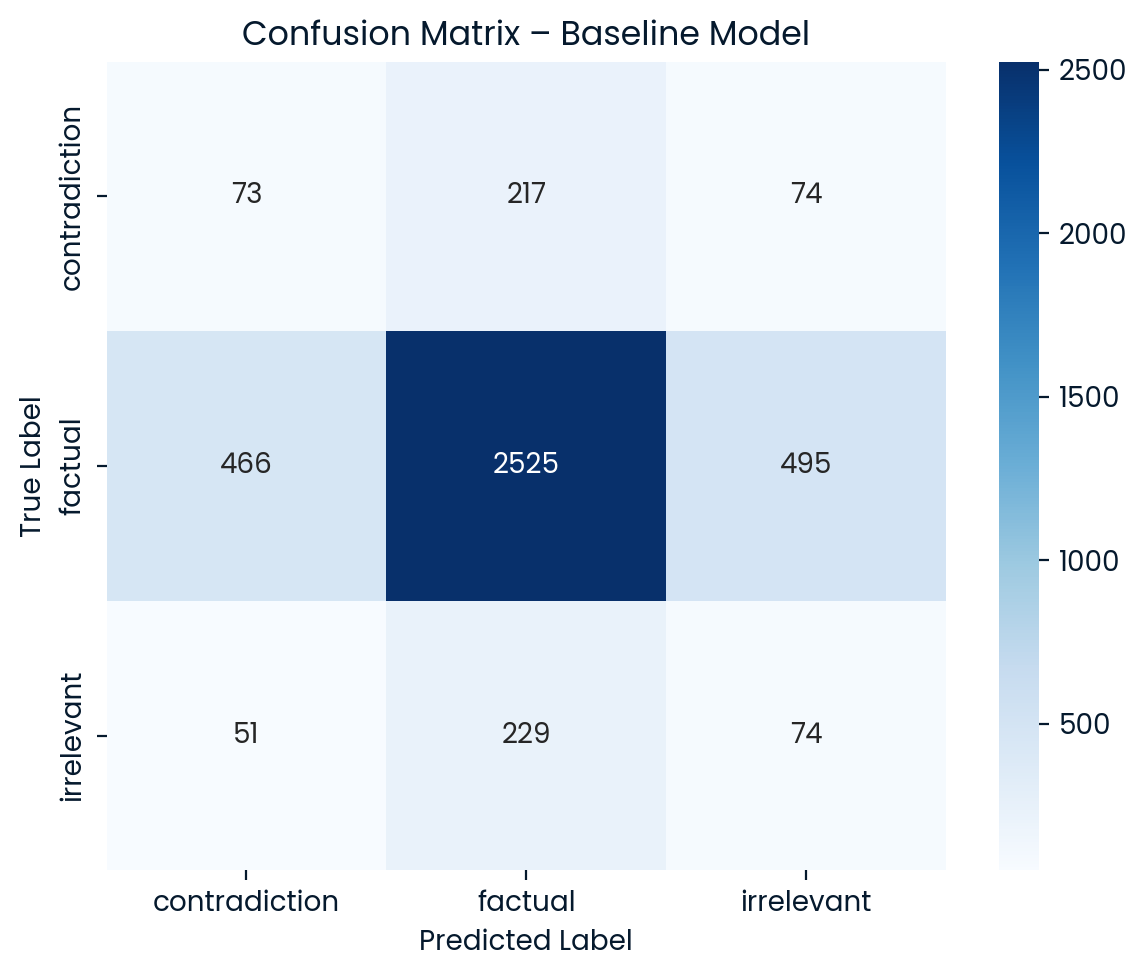

In [35]:
cm = confusion_matrix(y_val, val_preds, labels=pipeline.classes_)

plt.figure(figsize=(6, 5))
sns.heatmap(cm,annot=True,fmt="d",cmap="Blues", xticklabels=pipeline.classes_, yticklabels=pipeline.classes_)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Baseline Model")
plt.tight_layout()
plt.show()

The confusion matrix further clarifies the limitations of the baseline model. The model strongly favors the **factual** class, correctly identifying most factual samples but also **over-predicting** this label for other classes. A large proportion of **contradiction** and **irrelevant** instances are **misclassified as factual**, indicating that the model relies heavily on surface-level lexical overlap rather than relational or semantic cues. In particular, contradiction examples are rarely predicted correctly and are frequently confused with factual answers, suggesting that TF-IDF features are insufficient for capturing inconsistency between question, context, and answer. Similarly, irrelevant answers often share vocabulary with relevant content, leading to systematic confusion. 

Overall, the confusion matrix highlights a **strong majority-class bias** and reinforces the need for contextualized representations to model deeper semantic relationships.

---

### Fine-Tune a BERT Transformer

Given the limitations observed in the TF-IDF–based baseline model, I move to a transformer-based approach. I'll fine-tune a BERT model to jointly represent the question, context, and answer, allowing the model to capture deeper semantic relationships beyond surface-level lexical patterns.

**Preparing Text Inputs for the BERT Model**

In [5]:
train_texts = train_df.apply(combine_text, axis=1).tolist()

**Label Encoding**

I map the categorical answer types to integer labels to match the model’s classification output space.

In [6]:
le = LabelEncoder()
y = le.fit_transform(train_df["type"])

num_labels = len(le.classes_)
class_names = le.classes_

for i, label in enumerate(class_names):
    print(f"{i} -> {label}")

0 -> contradiction
1 -> factual
2 -> irrelevant


**Split the Data into Train and Validation Sets**

In [7]:
X_train, X_val, y_train, y_val = train_test_split(
    train_texts,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

**Computing Class Weights for Imbalanced Data**

Since the dataset exhibits a strong class imbalance, I compute class weights from the training labels and incorporate them into the loss function to reduce bias toward the majority class and encourage the model to better learn minority classes.

In [8]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

class_weights = torch.tensor(class_weights, dtype=torch.float)

for label_id, class_name in enumerate(class_names):
  print(f"Label {label_id} ({class_name}) -> weight: {class_weights[label_id].item():.4f}")

Label 0 (contradiction) -> weight: 3.8551
Label 1 (factual) -> weight: 0.4020
Label 2 (irrelevant) -> weight: 3.9530


**Load a Pre-Trained BERT**

In [9]:
# Load BERT model and tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name,num_labels=num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Move to GPU**

I move the model to the available computation device (GPU if available, otherwise CPU) to enable efficient training.

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model.to(device)

Using device: cuda


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

**Freeze and Unfreeze Strategy**

To stabilize fine-tuning and reduce overfitting, I freeze all BERT parameters and selectively unfreeze only the classification head and the last two transformer encoder layers. This strategy allows the model to adapt high-level semantic representations to the task while preserving the general language knowledge learned during pretraining.

In [11]:
# Freeze all parameters
for param in model.parameters():
    param.requires_grad = False

# Unfreeze classifier
for param in model.classifier.parameters():
    param.requires_grad = True

# Unfreeze last 2 BERT encoder layers
for param in model.bert.encoder.layer[-2:].parameters():
    param.requires_grad = True

**Preparing Training and Validation Data for BERT**

I tokenize the concatenated input texts using the BERT tokenizer with a maximum sequence length of 512 tokens. The resulting input IDs, attention masks, and encoded labels are converted into PyTorch tensors and organized into DataLoader objects for efficient batch-wise training and validation.

In [12]:
# Pre-process training text
MAX_LEN = 512

train_encodings = tokenizer(
    X_train,
    truncation=True,
    padding=True,
    max_length=MAX_LEN,
    return_tensors="pt"
)

train_dataset = TensorDataset(
    train_encodings["input_ids"],
    train_encodings["attention_mask"],
    torch.tensor(y_train, dtype=torch.long)
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [13]:
# Pre-process validation text
val_encodings = tokenizer(
    X_val,
    truncation=True,
    padding=True,
    max_length=MAX_LEN,
    return_tensors="pt"
)

val_dataset = TensorDataset(
    val_encodings["input_ids"],
    val_encodings["attention_mask"],
    torch.tensor(y_val, dtype=torch.long)
)

val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

**Loss Function and Optimization Strategy**

I optimize the model using the AdamW optimizer, applied only to trainable parameters. To mitigate class imbalance in the dataset, I employ a weighted cross-entropy loss, where class weights are computed from the training labels.

In [14]:
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),lr=2e-5)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

**Fine-Tuning Procedure**

I fine-tune the model over several epochs using a custom loop that alternates between training and validation, tracking loss and accuracy to assess learning progress and generalization.

In [15]:
EPOCHS = 3

for epoch in range(EPOCHS):

    print(f"Epoch {epoch+1}/{EPOCHS}")
    model.train()
    train_loss = 0
    train_preds, train_true = [], []

    for step, (input_ids, attention_mask, labels) in enumerate(train_loader, 1):
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        preds = torch.argmax(outputs.logits, dim=1)
        train_preds.extend(preds.cpu().numpy())
        train_true.extend(labels.cpu().numpy())

    train_acc = accuracy_score(train_true, train_preds)
    avg_train_loss = train_loss / len(train_loader)

    # ===== VALIDATION =====
    model.eval()
    val_loss = 0
    val_preds, val_true = [], []

    with torch.no_grad():
        for input_ids, attention_mask, labels in val_loader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            loss = criterion(outputs.logits, labels)
            val_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_true.extend(labels.cpu().numpy())

    val_acc = accuracy_score(val_true, val_preds)
    avg_val_loss = val_loss / len(val_loader)


    print(
        f"- accuracy: {train_acc:.4f} "
        f"- loss: {avg_train_loss:.4f} "
        f"- val_accuracy: {val_acc:.4f} "
        f"- val_loss: {avg_val_loss:.4f}"
    )

Epoch 1/3
- accuracy: 0.8865 - loss: 0.5658 - val_accuracy: 0.9657 - val_loss: 0.2980
Epoch 2/3
- accuracy: 0.9476 - loss: 0.2554 - val_accuracy: 0.9577 - val_loss: 0.2309
Epoch 3/3
- accuracy: 0.9543 - loss: 0.2181 - val_accuracy: 0.9686 - val_loss: 0.2443


The training dynamics show a **stable and effective** fine-tuning process. 

- **Training accuracy increases** consistently across epochs (from 0.89 to 0.95), while **training loss decreases** substantially, indicating that the model is successfully adapting to the task.

- **Validation** performance remains strong throughout training. After an initial improvement in Epoch 1, validation accuracy stays above 0.95, suggesting **good generalization**. The slight increase in validation loss in the final epoch, despite higher validation accuracy, indicates the onset of mild **overfitting** but not to a degree that degrades overall performance.

Overall, the results suggest that **three epochs are sufficient** for convergence. Additional training would likely yield diminishing returns and could increase the risk of overfitting, particularly given the class imbalance and the high validation accuracy already achieved.

**Model Evaluation**

Lastly, I evaluate the fine-tuned BERT model and compare its performance with the  baseline to assess the gains from contextual modeling.

**1. Generate Validation Set Predictions**

In [16]:
model.eval()

all_preds = []
all_true = []

with torch.no_grad():
    for input_ids, attention_mask, labels in val_loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_true.extend(labels.cpu().numpy())

**2. Evaluate the Fine-Tuned BERT**

In [17]:
print(classification_report(all_true,all_preds,target_names=class_names))

               precision    recall  f1-score   support

contradiction       0.94      0.74      0.83       364
      factual       0.97      0.99      0.98      3486
   irrelevant       0.99      0.94      0.97       354

     accuracy                           0.97      4204
    macro avg       0.97      0.89      0.93      4204
 weighted avg       0.97      0.97      0.97      4204



The **macro F1-score of 0.93** indicates that the model performs consistently well across all three classes, despite the inherent class imbalance in the dataset. This suggests that the model does not rely solely on the dominant factual class and is able to generalize its predictions across different answer types.

The **factual and irrelevant classes** show strong and balanced **precision–recall** behavior, reflecting the model’s ability to distinguish context-aligned answers from off-topic responses with high reliability.

The **contradiction class** remains the most challenging. While precision is high, **recall is comparatively lower**, indicating that the model tends to be cautious when predicting contradictions and may overlook some subtle contradictory cases. This behavior is expected given the semantic overlap between factual and contradictory answers and the limited size of the contradiction class.

Overall, despite the lower recall for contradictions, the model demonstrates stable and well-balanced performance across classes. Considering the task difficulty and dataset characteristics, the results are satisfactory, and the model provides a reliable foundation for downstream evaluation and submission.

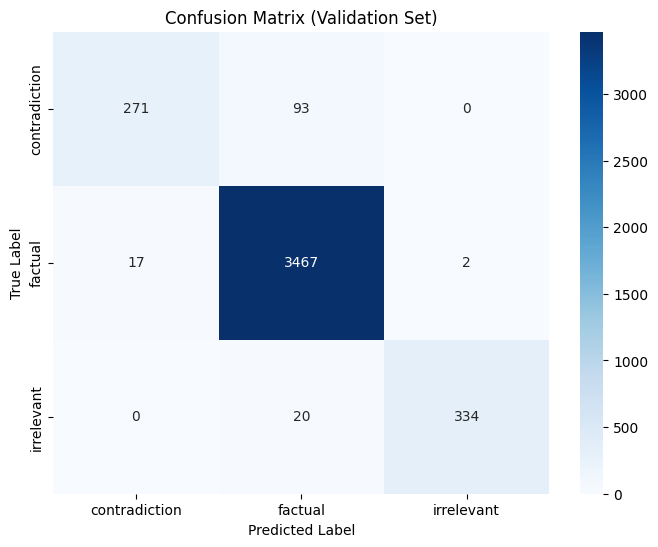

In [18]:
cm = confusion_matrix(val_true, val_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm,annot=True,fmt="d",cmap="Blues",xticklabels=class_names,yticklabels=class_names)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Validation Set)")
plt.show()

The confusion matrix shows that the model separates the **factual class** very effectively. The vast majority of factual instances are **correctly classified**, with only a small number being misclassified as contradiction or irrelevant. This indicates that the model has learned strong signals for identifying contextually grounded and accurate answers.

For the **irrelevant class**, predictions are also **highly consistent**. Almost all irrelevant answers are correctly identified, with only a limited number being confused with factual answers. This suggests that the model can reliably detect when an answer does not align with the given question–context pair.

The main source of confusion appears in the **contradiction class**. While most contradiction examples are correctly predicted, a noticeable portion is **misclassified as factual**. This pattern reflects the semantic difficulty of the task: contradictory answers often share surface-level vocabulary and entities with factual ones, making them harder to distinguish without deeper semantic reasoning.

Importantly, there is almost **no confusion** between **contradiction and irrelevant** classes, indicating that the model **does not rely on random or shallow cues**. Instead, the errors are concentrated in **semantically adjacent classes**, which is expected for this problem setting.

Overall, the confusion matrix supports the macro-level evaluation results. Although contradiction detection remains challenging, the error patterns are interpretable and consistent with the nature of the task, and the model demonstrates well-structured decision boundaries across classes.

**Single-Example Inference with Fine-Tuned BERT**

I define a small utility function to run inference on a single (question, context, answer) triple using the fine-tuned BERT model.

In [23]:
def bert_classify_example(question, context, answer):
    """
    Classifies a single (question, context, answer) triple into:
    - contradiction
    - factual
    - irrelevant
    """

    combined_text = (
        "question: " + question + " "
        "context: " + context + " "
        "answer: " + answer
    )

    encoding = tokenizer(
        combined_text,
        padding='max_length',
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )

    encoding = {k: v.to(device) for k, v in encoding.items()}

    model.eval()
    with torch.no_grad():
        outputs = model(
            input_ids=encoding["input_ids"],
            attention_mask=encoding["attention_mask"]
        )

        pred_label = torch.argmax(outputs.logits, dim=1).item()

    label_map = {
        0: "contradiction",
        1: "factual",
        2: "irrelevant"
    }

    return label_map[pred_label]

**Example Prediction with Fine-Tuned BERT**

In [25]:
example_question = "Does regular exercise reduce the risk of heart disease?"

example_context = (
    "Regular physical activity is associated with improved cardiovascular health. "
    "Clinical studies indicate that consistent exercise can lower blood pressure, "
    "improve cholesterol levels, and reduce the overall risk of heart disease, "
    "although results may vary depending on intensity and individual factors."
)

example_answer = "Regular exercise generally improves fitness, but it does not meaningfully reduce the risk of heart disease."

bert_classify_example(
    example_question,
    example_context,
    example_answer
)

'contradiction'

In this example, the model predicts the **contradiction** class, as the answer explicitly negates the causal relationship between exercise and heart disease that is supported by the context.

This qualitative result suggests that the model is able to **detect semantic inconsistency** between the answer and the provided context, rather than relying solely on surface-level word overlap.

---

## Test Set Submission

In this final step, I apply the fine-tuned BERT model to the unseen test set and generate predictions for each example. The predicted labels are then mapped back to their original class names and saved in the required JSON format for submission.

In [ ]:
# Pre-Process Test Texts
test_texts = test_df.apply(combine_text, axis=1).tolist()

test_encodings = tokenizer(
    test_texts,
    truncation=True,
    padding=True,
    max_length=512,
    return_tensors="pt"
)

test_dataset = TensorDataset(
    test_encodings["input_ids"],
    test_encodings["attention_mask"]
)

test_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False
)

In [ ]:
# Generate Test Set Predictions
model.eval()
all_preds = []

with torch.no_grad():
    for input_ids, attention_mask in test_loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())

predicted_labels = le.inverse_transform(all_preds)

In [28]:
# Make submission
submission = []

for idx, label in zip(test_df["ID"], predicted_labels):
    submission.append({
        "ID": idx,
        "type": label.capitalize()
    })

with open("submission.json", "w") as f:
    json.dump(submission, f, indent=2)

print("✅ submission.json created successfully")

✅ submission.json created successfully


---

## Conclusion and Thank You 

In this project, I have developed an end-to-end pipeline to tackle the critical challenge of identifying incorrect or inconsistent AI responses. By moving from simple word-matching to deep, context-grounded reasoning, I have established a framework that rigorously audits AI-generated knowledge to ensure its reliability for digital learners. This diagnostic approach provides a scalable way to transform AI from a potential source of misinformation into a truly dependable mentor.

I extend my sincere thanks for taking the time to thoroughly review and evaluate the details, analyses, and semantic solutions of this project. I hope this work has demonstrated how smartly technology can guide such critical decisions and foster a more reliable digital learning environment.

**If you liked and wish to support my project, please don't forget to vote!** I wish you a wonderful and productive day! 🌟